<a href="https://colab.research.google.com/github/jiangyuan2li/scDGM/blob/master/GMVAE/scGMVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## scGMVAE
This framework is modified from scVI with a Gaussian mixture latent variable variantion.

In [479]:
!pip install scanpy
# !pip3 install pyro-ppl

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [0]:
import scanpy as sc

In [0]:
import anndata
from torch.distributions import Categorical, Normal, kl_divergence as kl
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import adjusted_rand_score as ARI

In [0]:
from sklearn.cluster import KMeans
import sklearn

# Read data

In [0]:
class AnnDataset(torch.utils.data.Dataset):
    def __init__(self, X_ann):
        # TODO
        # 1. Initialize file paths or a list of file names.
        self.X = X_ann.obsm['X']
        self.local_mean = X_ann.obs['local_mean']
        self.local_var = X_ann.obs['local_var']
#        self.batch_index = X_ann.obs['batch_index']
#        self.fake_labels = X_ann.obs['fake_labels']
    def __getitem__(self, index):
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        sample_x = self.X[index]
        sample_local_mean = self.local_mean[index]
        sample_local_var = self.local_var[index]
#        sample_batch_index = self.batch_index[index]
#        sample_fake_labels = self.fake_labels[index]

        sample = {'x': sample_x, 'local_mean':sample_local_mean,'local_var':sample_local_var}
#                 'batch_index':sample_batch_index,'fake_labels':sample_fake_labels}
        return sample

    def __len__(self):
        # the total size of your dataset.
        return len(self.X)



In [0]:
raw_adata = sc.read_h5ad("cortex_scAnnData.h5ad")

In [487]:
raw_adata.obsm

AxisArrays with keys: X, X_pca, X_tsne, X_umap

In [488]:
raw_adata.obsm['X']

array([[8.220e+02, 0.000e+00, 0.000e+00, ..., 7.000e+00, 1.000e+01,
        6.000e+00],
       [8.690e+02, 0.000e+00, 0.000e+00, ..., 9.000e+00, 0.000e+00,
        1.100e+01],
       [1.237e+03, 1.000e+00, 0.000e+00, ..., 1.000e+01, 5.000e+00,
        1.800e+01],
       ...,
       [3.760e+02, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [3.030e+02, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.420e+02, 2.800e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        2.000e+00]], dtype=float32)

In [0]:
local_mean = np.log(raw_adata.obsm['X'].sum(axis=1)).mean()

local_var = np.log(raw_adata.obsm['X'].sum(axis=1)).var()

raw_adata.obs['local_mean'] = local_mean

raw_adata.obs['local_var'] = local_var

#raw_adata.obs['clusters'] = raw_adata.obs['Group']
BATCH_SIZE = 128

ann_dataset = AnnDataset(raw_adata)
train_loader = torch.utils.data.DataLoader(dataset=ann_dataset,
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,drop_last = True)

# Loss

In [0]:
def log_zinb_positive(x, mu, theta, pi, eps=1e-8):
    """
    Variables:
    mu: mean of the negative binomial (has to be positive support) (shape: minibatch x genes)
    theta: inverse dispersion parameter (has to be positive support) (shape: minibatch x genes)
    pi: logit of the dropout parameter (real support) (shape: minibatch x genes)
    eps: numerical stability constant
    """

    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(
            1, theta.size(0)
        )  # In this case, we reshape theta for broadcasting

    softplus_pi = F.softplus(-pi)
    #print("softplus_pi", softplus_pi)
    log_theta_eps = torch.log(theta + eps)
    #print("log_theta_eps", log_theta_eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    #print("log_theta_mu_eps", log_theta_mu_eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)
    #print("pi_theta_log", pi_theta_log)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    #print("case_zero", case_zero)
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)
    #print("mul_case_zero", mul_case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)

    res = mul_case_zero + mul_case_non_zero

    return res
  
def log_normal(x, mu, var, eps = 0.0, dim = 0):
    if eps > 0.0:
        var = var + eps
    return torch.sum(-1/2 * (torch.log(2 * torch.tensor(np.pi)) + torch.log(var) + (x - mu)**2 / var), dim = 1)

# Model

## Q(Y|X) Encoder

In [0]:
class qy_given_x_encoder(nn.Module):
    def __init__(self, n_in, n_hidden, n_clusters):
        super(qy_given_x_encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.BatchNorm1d(n_hidden, momentum=0.01, eps=0.001),
            nn.ReLU(),
          )
        
        self.logits = nn.Sequential(
            nn.Linear(n_hidden, n_clusters),
            nn.BatchNorm1d(n_clusters),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)

        logit = self.logits(x)

        q_y_given_x = Categorical(logits=logit)

        return q_y_given_x

## Q(Z|X,Y) Encoder

In [0]:
class qz_given_xy_encoder(nn.Module):
    def __init__(self, 
                 n_in, 
                 n_clusters,
                 n_hidden, 
                 n_out, 
                 n_iw_samples, 
                 n_mc_samples, 
                 latent_size):
      
      super(qz_given_xy_encoder, self).__init__()
      self.n_clusters = n_clusters
      self.n_iw_samples = n_iw_samples
      self.n_mc_samples = n_mc_samples
      self.latent_size = latent_size

      self.encoder = nn.Sequential(
          nn.Linear(n_in + n_clusters, n_hidden),
          nn.BatchNorm1d(n_hidden),
          nn.ReLU()
      )
      self.mean_encoder = nn.Linear(n_hidden, n_out)
      self.var_encoder = nn.Sequential(
          nn.Linear(n_hidden, n_out),
          nn.Softplus()
      )
        
    def forward(self, x: torch.Tensor, y):
      y = y.unsqueeze(0).repeat(x.size(0),1)
      cat = torch.cat([x,y], dim=1).cuda()
      q = self.encoder(cat)
      
      q_m = self.mean_encoder(q)
      q_v = self.var_encoder(q)

      q_z_given_x_y = Normal(q_m, torch.sqrt(q_v))

      z_mean = q_z_given_x_y.mean

      z = q_z_given_x_y.rsample(torch.Size([
                                  self.n_iw_samples * self.n_mc_samples
                                ]))

      return q_z_given_x_y, z_mean, z

## P(Z|Y) Encoder

In [0]:
class pz_given_y_encoder(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(pz_given_y_encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        self.mean_encoder = nn.Linear(n_hidden, n_out)
        self.var_encoder = nn.Sequential(
            nn.Linear(n_hidden, n_out),
            nn.Softplus()
        )
        
    def forward(self, y):
        q = self.encoder(y)
        
        p_m = self.mean_encoder(q)
        p_v = self.var_encoder(q)

        p_z_given_y = Normal(p_m, torch.sqrt(p_v))

        z_mean = p_z_given_y.mean
        
        return p_z_given_y, z_mean

## P(X|Z) Decoder

In [0]:
class px_given_z_decoder(nn.Module):
    def __init__(self, n_in, n_clusters, n_hidden, n_out):
        super(px_given_z_decoder, self).__init__()
        self.px_decoder = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.BatchNorm1d(n_hidden, momentum=0.01, eps=0.001),
            nn.ReLU()
        )
        
        self.decoder_pi = nn.Sequential(
            nn.Linear(n_hidden, n_out),
            nn.BatchNorm1d(n_out),
            nn.Softplus(),
        )

        self.decoder_p = nn.Sequential(
            nn.Linear(n_hidden, n_out),
            nn.BatchNorm1d(n_out),
            nn.Softplus(),
        )

        self.decoder_log_r = nn.Sequential(
            nn.Linear(n_hidden, n_out),
        )
        
    def forward(self, z: torch.Tensor):
        z = self.px_decoder(z)
        
        pi = self.decoder_pi(z)
        p = self.decoder_p(z)
        log_r = self.decoder_log_r(z)

        return pi, p, log_r

## GMVAE

In [0]:
class GMVAE(nn.Module):
    def __init__(self, 
                 n_input, 
                 n_hidden=128, 
                 latent_size=32, 
                 n_clusters=7, 
                 n_iw_samples=1, 
                 n_mc_samples=1, 
                 kl_weight=1,
                 warm_up_weight=1):
        super(GMVAE, self).__init__()
        self.latent_size = latent_size
        self.n_iw_samples = n_iw_samples
        self.n_mc_samples = n_mc_samples
        self.n_clusters = n_clusters
        self.warm_up_weight = warm_up_weight
        self.kl_weight = kl_weight
        self.recon_theta = nn.Parameter(
              torch.abs(
                  torch.randn(n_input)
              ).clamp(0,100000)
            ) 

        self.q_y_x_encoder = qy_given_x_encoder(n_input, n_hidden, n_clusters)
        self.q_z_xy_encoder = nn.ModuleList([])
        self.p_z_y_encoder = nn.ModuleList([])
        self.p_x_z_decoder = nn.ModuleList([])

        for k in range(n_clusters):
            self.q_z_xy_encoder.append(qz_given_xy_encoder(
                n_input, 
                n_clusters, 
                n_hidden, 
                self.latent_size, 
                self.n_iw_samples, 
                self.n_mc_samples, 
                self.latent_size
              ))
            self.p_z_y_encoder.append(
                pz_given_y_encoder(n_clusters, n_hidden, self.latent_size).cuda()
            )
            self.p_x_z_decoder.append(
                px_given_z_decoder(self.latent_size, n_clusters, n_hidden, n_input).cuda()
            )

        self.q_z_xy = [None] * self.n_clusters
        self.p_z_y = [None] * self.n_clusters
        self.z = [None] * self.n_clusters
        kl_divergence_z_mean = [None] * self.n_clusters
        log_p_x_given_z_mean = [None] * self.n_clusters
        p_x_means = [None] * self.n_clusters
        mean_of_p_x_given_z_variances = [None] * self.n_clusters
        variance_of_p_x_given_z_means = [None] * self.n_clusters
        self.p_z_mean = [None] * self.n_clusters
        self.p_x_z = [None] * self.n_clusters
        self.p_z_means = []
        self.p_z_variances = []
        self.q_z_means = []
        self.q_z_variances = []

        # p(y)
        p_y_probabilities = torch.ones(self.n_clusters)/self.n_clusters
        p_y_logits = torch.log(p_y_probabilities).cuda()
        self.p_y = Categorical(logits=p_y_logits)
        self.p_y_probabilities = self.p_y.probs.unsqueeze(0)
        
    def forward(self, x):
      # Y latent space
        # p(y)
        p_y_samples = self.p_y.sample(sample_shape=torch.Size([x.size(0),1]))
        self.p_y_samples = torch.zeros([x.size(0), self.n_clusters]).cuda()
        for row in range(len(self.p_y_samples)):
          self.p_y_samples[row][p_y_samples[row]] = 1

        # q(y|x)
        y = torch.eye(self.n_clusters).cuda()
        self.q_y_x = self.q_y_x_encoder(x)
        self.q_y_logits = torch.log(self.q_y_x.probs) - torch.log1p(-self.q_y_x.probs)
        self.q_y_probabilities = torch.mean(self.q_y_x.probs, dim=0)


      # Z Latent Space
        z_mean = [None]*self.n_clusters
        for k in range(self.n_clusters):
          # q(z|x,y)
          self.q_z_xy[k], z_mean[k], self.z[k] = self.q_z_xy_encoder[k](x, y[k])
          
          #p(z|y)
          self.p_z_y[k], self.p_z_mean[k] = self.p_z_y_encoder[k](y[k].unsqueeze(0))

        self.y = self.q_y_x.probs
        
      # Decoder X
        pi = [None] * self.n_clusters
        p = [None] * self.n_clusters
        log_r = [None] * self.n_clusters
        for k in range(self.n_clusters):
          # p(x|z)
          pi[k], p[k], log_r[k] = self.p_x_z_decoder[k](self.z[k].squeeze())

      # Loss
        kl_divergence_y = kl(self.q_y_x, self.p_y).mean()

        z_reshaped = [
            torch.reshape(
                self.z[k],
                shape=[
                    self.n_iw_samples,
                    self.n_mc_samples,
                    -1,
                    self.latent_size
                ]
            )
            for k in range(self.n_clusters)
        ]
        
        kl_divergence_z_mean = torch.zeros(x.size(0)).cuda()
        reconstruct_losses = torch.zeros(self.n_clusters, x.size(0)).cuda()
        for k in range(self.n_clusters):
          log_q_z_given_x_y = torch.sum(
              self.q_z_xy[k].log_prob(
                  z_reshaped[k]
              ),
              -1
          )

          log_p_z_given_y = torch.sum(
              self.p_z_y[k].log_prob(
                  z_reshaped[k]
              ),
              -1
          )

          kl_divergence_z_mean += torch.mean(
              log_q_z_given_x_y - log_p_z_given_y
          ) * self.y[:,k]

          reconstruct_losses[k] = -log_zinb_positive(x, pi[k], p[k], log_r[k]).sum(dim = 1)

        self.pi = pi
        self.p = p
        self.log_r = log_r        

        self.kl_divergence_z = torch.mean(kl_divergence_z_mean)
        self.kl_divergence_y = torch.mean(kl_divergence_y)
        self.reconstruction_error = torch.mean(reconstruct_losses)

        self.lower_bound_weighted = (
            self.reconstruction_error
            + self.warm_up_weight * self.kl_weight * (
                self.kl_divergence_z + kl_divergence_y
            )
        )

        return self.lower_bound_weighted, self.kl_divergence_z, self.kl_divergence_y, self.reconstruction_error
    
    def get_latent_cluster(self, x):
      with torch.no_grad():
        y = torch.eye(self.n_clusters).cuda()
        latent = torch.zeros(self.n_clusters, x.size(0),self.latent_size)
        for k in range(self.n_clusters):
          self.q_z_xy_encoder[k].eval()
          _, _, z = self.q_z_xy_encoder[k](x, y[k])
          latent[k] = z.squeeze()
          self.q_z_xy_encoder[k].train()

      return latent.permute(1,0,2)

# Train

In [0]:
gmvae = GMVAE(n_input=raw_adata.obsm['X'].shape[1], 
              n_hidden=128, 
              latent_size=32, 
              n_clusters=7,
              kl_weight=1).cuda()

learning_rate=1e-2
weight_decay = 1e-6
eps = 0.01
epoch = 0
params = gmvae.parameters()
optimizer = torch.optim.AdamW(
            params, lr=learning_rate, weight_decay=weight_decay
        )   

In [0]:
def train(model, train_loader,optimizer, val_loader = None, start_epoch = 0,num_epochs=30, seed=1,
          save_path = "train_with_tsne/"):

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

  for epoch in range(start_epoch,num_epochs):
    print(optimizer.param_groups[0]['lr'])

    for i, sample in enumerate(train_loader):
      x = sample['x'].cuda()
      
      optimizer.zero_grad()
      loss, kl_divergence_z, kl_divergence_y, reconstruction_error = model(x)
      loss.backward()
      param1 = optimizer.param_groups[0]
      nn.utils.clip_grad_norm(model.parameters(), 5)
      #print(param1)
      optimizer.step()
      param2 = optimizer.param_groups[0]
      #print(param2)

      if i % 5 == 0:
          print("Epoch[{}/{}], Step [{}/{}],  Loss: {:.4f}, KL Div Z: {:.4f}, KL Div Y: {:.4f}, Recon Loss: {:.4f}".format(
                                  epoch, num_epochs, i, len(train_loader), loss.item(), kl_divergence_z.item(), kl_divergence_y.item(), reconstruction_error.item()))
    scheduler.step()

In [499]:
train(gmvae,train_loader,optimizer, num_epochs = 50, start_epoch=epoch)

0.01
Epoch[0/50], Step [0/23],  Loss: 1271.6997, KL Div Z: 17.9513, KL Div Y: 0.1198, Recon Loss: 1253.6285


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  app.launch_new_instance()


Epoch[0/50], Step [5/23],  Loss: 1275.4128, KL Div Z: 17.4782, KL Div Y: 0.1198, Recon Loss: 1257.8148
Epoch[0/50], Step [10/23],  Loss: 1344.3419, KL Div Z: 17.2376, KL Div Y: 0.1197, Recon Loss: 1326.9846
Epoch[0/50], Step [15/23],  Loss: 1331.7032, KL Div Z: 17.4591, KL Div Y: 0.1199, Recon Loss: 1314.1243
Epoch[0/50], Step [20/23],  Loss: 1295.5509, KL Div Z: 17.2164, KL Div Y: 0.1194, Recon Loss: 1278.2152
0.009990133642141357
Epoch[1/50], Step [0/23],  Loss: 1326.8552, KL Div Z: 17.0217, KL Div Y: 0.1189, Recon Loss: 1309.7147
Epoch[1/50], Step [5/23],  Loss: 1288.9768, KL Div Z: 18.1959, KL Div Y: 0.1192, Recon Loss: 1270.6617
Epoch[1/50], Step [10/23],  Loss: 1267.0295, KL Div Z: 17.5810, KL Div Y: 0.1200, Recon Loss: 1249.3285
Epoch[1/50], Step [15/23],  Loss: 1290.8887, KL Div Z: 17.6146, KL Div Y: 0.1194, Recon Loss: 1273.1547
Epoch[1/50], Step [20/23],  Loss: 1285.7935, KL Div Z: 17.8159, KL Div Y: 0.1196, Recon Loss: 1267.8579
0.00996057350657239
Epoch[2/50], Step [0/23], 

KeyboardInterrupt: ignored

# Evaluation

In [0]:
latent = gmvae.get_latent_cluster(torch.Tensor(raw_adata.obsm['X']).cuda())

In [510]:
latent.size()

torch.Size([3005, 7, 32])

In [511]:
latent = np.argmax(latent,axis=1)
latent.shape

torch.Size([3005, 32])

In [0]:
post_adata = sc.AnnData(X=raw_adata.X)
post_adata.obsm["X_dca"] = latent.cpu().detach().numpy()
post_adata.obs['cell_type'] = raw_adata.obs['clusters']

In [513]:
sc.pp.neighbors(post_adata, use_rep="X_dca", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)

/usr/local/lib/python3.6/dist-packages/scanpy/neighbors/__init__.py:89: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

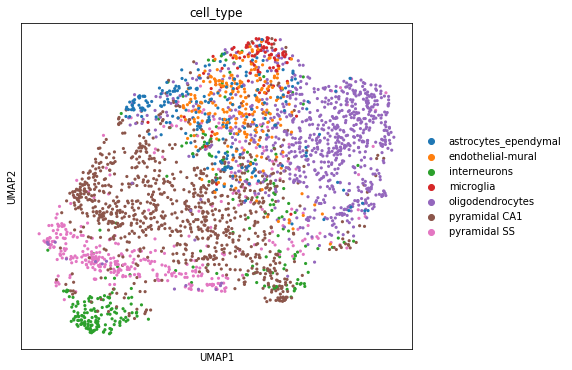

In [515]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax)

In [0]:
raw_adata.obs['clusters']

In [0]:
ARI(l,raw_adata.obs['clusters'])

In [0]:
NMI(l,raw_adata.obs['clusters'])

In [0]:
post_adata = anndata.AnnData(X=raw_adata.X)
post_adata.obsm["X_scVI"] = latent.detach().numpy()
post_adata.obs['cell_type'] = raw_adata.obs['clusters']

In [0]:
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)

In [0]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax)#, show=show_plot)

In [0]:
sc.tl.tsne(post_adata, use_rep="X_scVI")
sc.pl.tsne(post_adata,color=['cell_type'])#,save="_cortex_scvi.png")

In [0]:
from sklearn.cluster import KMeans

out = KMeans(n_clusters=7).fit(latent)

out.labels_

sklearn.metrics.normalized_mutual_info_score(out.labels_,raw_adata.obs['clusters'])

In [0]:
sklearn.metrics.adjusted_rand_score(out.labels_,raw_adata.obs['clusters'])